# MiniSeg

## Initialization

In [ ]:
!pip install -qU torch accelerate transformers transformers[torch] datasets sentence-transformers evaluate nltk segeval pynvml wandb

In [ ]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [ ]:
import wandb
from google.colab import userdata


os.environ["WANDB_PROJECT"] = "miniseg"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

wandb.login(key=userdata.get('WANDB_API_KEY'))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


### Data

In [ ]:
from datasets import load_dataset

data_files = {
    "train": "data/partitions/yt_seg.train.json",
    "validation": "data/partitions/yt_seg.val.json",
    "test": "data/partitions/yt_seg.test.json"
}

dataset = load_dataset("retkowski/ytseg", data_files=data_files)


def map_fn(data):
  data["targets"] = [1 if c == '1' else 0 for c in data["targets"][2:]] # Remove '|=' prefix
  return data

dataset = dataset.map(
    map_fn,
    remove_columns=["channel_id", "video_id", "audio_path"]
)

dataset = dataset.filter(
    lambda row: len(row["text"]) < 800 and max(len(sentence) for sentence in row["text"]) < 500
)

dataset = dataset.rename_column("targets", "labels")

dataset.set_format('torch')
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 14377
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1256
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1266
    })
})


In [ ]:
dataset.save_to_disk("ytseg_clean")

Saving the dataset (0/1 shards):   0%|          | 0/14377 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1256 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1266 [00:00<?, ? examples/s]

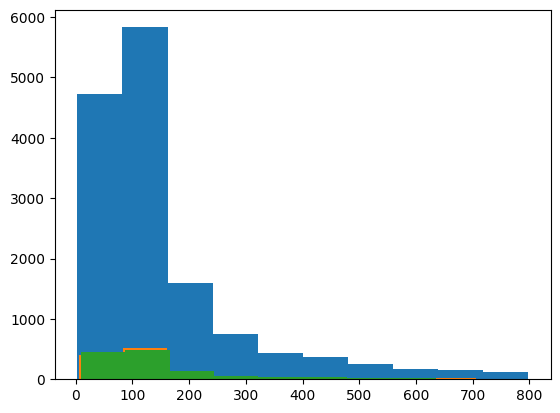

In [ ]:
import matplotlib.pyplot as plt

plt.hist([len(text) for text in dataset["train"]["text"]])
plt.hist([len(text) for text in dataset["validation"]["text"]])
plt.hist([len(text) for text in dataset["test"]["text"]])
plt.show()

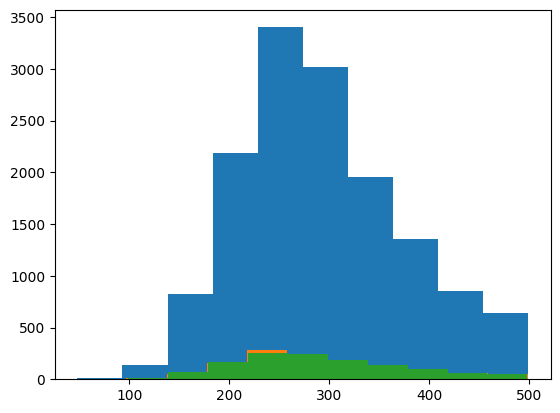

In [ ]:
plt.hist([max(len(sentence) for sentence in text) for text in dataset["train"]["text"]])
plt.hist([max(len(sentence) for sentence in text) for text in dataset["validation"]["text"]])
plt.hist([max(len(sentence) for sentence in text) for text in dataset["test"]["text"]])
plt.show()

### The Model

In [ ]:
import numpy as np
import torch
import gc
from torch import nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from transformers.modeling_outputs import TokenClassifierOutput

device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert device == 'cuda'

class MiniSeg(nn.Module):
  def __init__(self, sentence_encoder, doc_encoder):
    super(MiniSeg, self).__init__()
    self.num_labels = 2
    self.sentence_encoder = sentence_encoder
    self.doc_encoder = doc_encoder

  def forward(self, texts, labels_list):
    batch_sentence_embeddings = [
        self._get_sentence_encoding(self.sentence_encoder(**text), text["attention_mask"]) for text in texts
    ]

    lengths = torch.tensor([len(text) for text in batch_sentence_embeddings]).to(device)

    padded_embeddings = rnn_utils.pad_sequence(batch_sentence_embeddings, batch_first=True)

    masks = self._generate_masks(
        lengths,
        padded_embeddings.size(1),
        padded_embeddings.size(0),
    ).float()

    result = self.doc_encoder(
        inputs_embeds=padded_embeddings,
        attention_mask=masks,
        labels=labels_list,
        return_dict=True
    )
    return result

  def _generate_masks(self, lengths, max_len, batch_size):
    return torch.arange(max_len).to(device).expand(len(lengths), max_len) < lengths.unsqueeze(1)

  def _get_sentence_encoding(self, encoder_output, attention_mask):
    # Perform pooling
    sentence_embeddings = self.mean_pooling(encoder_output, attention_mask)

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings

  def mean_pooling(self, model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

  def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
    self.sentence_encoder.gradient_checkpointing_enable(gradient_checkpointing_kwargs)
    self.doc_encoder.gradient_checkpointing_enable(gradient_checkpointing_kwargs)


In [ ]:
from transformers import AutoTokenizer, AutoModel, RoFormerForTokenClassification, RoFormerConfig
from sentence_transformers import SentenceTransformer

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L6-v2')
sentence_encoder = AutoModel.from_pretrained('sentence-transformers/paraphrase-MiniLM-L6-v2')

cfg = RoFormerConfig(embedding_size=384, num_hidden_layers=12, num_attention_heads=8, num_labels=2)
doc_encoder = RoFormerForTokenClassification(cfg)

model = MiniSeg(sentence_encoder, doc_encoder).to(device)

## Training

In [ ]:
class CustomDataCollator:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer

  def __call__(self, entries):
    # Why tf is this a list

    texts, labels_list = zip(*[ # Super-cool "splat" operator
        self._process_entry(entry) for entry in entries
    ])

    padded_labels_list = torch.nn.utils.rnn.pad_sequence(labels_list, batch_first=True, padding_value=-100)
    batch = {
        "texts": texts,
        "labels_list": torch.tensor(padded_labels_list)
    }

    return batch

  def _process_entry(self, entry):
    text = self.tokenizer(entry["text"], padding=True, truncation=True, return_tensors='pt')
    labels = self._process_labels_string(entry["labels"])
    return text, labels

  def _process_labels_string(self, labels):
    return torch.tensor([int(c) for c in labels])


In [ ]:
import nltk
import segeval
import evaluate

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_boundary_similarity(result: str, actual: str):
  s1 = segeval.convert_nltk_to_masses(result, boundary_symbol='1')
  s2 = segeval.convert_nltk_to_masses(actual, boundary_symbol='1')
  score = segeval.boundary_similarity(s1, s2)
  return float(score)

def compute_segment_metrics(predictions, labels):
  pk_scores = []
  b_scores = []

  for p, l in zip(predictions, labels):
    invalid_indices = np.where(l == -100)[0]
    if len(invalid_indices) != 0:
      last_index = invalid_indices[0]
      p = p[:last_index]
      l = l[:last_index]

    # Last entry needs to be chopped off because
    # in NLTK a bit means a boundary while in dataset
    # a bit means a sentence
    predicted_boundaries = "".join([str(c) for c in p])[:-1]
    actual_boundaries = "".join([str(c) for c in l])[:-1]

    pk = nltk.pk(actual_boundaries, predicted_boundaries)
    b = compute_boundary_similarity(predicted_boundaries, actual_boundaries)

    pk_scores.append(pk)
    b_scores.append(b)

  average_pk = sum(pk_scores)/len(pk_scores)
  average_b = sum(b_scores)/len(b_scores)

  return {
      "pk": average_pk,
      "boundary_similarity": average_b
  }

def compute_individual_metrics(predictions, labels):
  predictions = np.ravel(predictions)
  labels = np.ravel(labels)
  valid_indices = np.where(labels != -100)

  predictions = predictions[valid_indices]
  labels = labels[valid_indices]

  return {
    "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
    "precision": precision_metric.compute(predictions=predictions, references=labels)["precision"],
    "recall": recall_metric.compute(predictions=predictions, references=labels)["recall"],
    "f1": f1_metric.compute(predictions=predictions, references=labels)["f1"]
  }


def compute_metrics(eval_pred):
  logits = eval_pred.predictions
  labels = eval_pred.label_ids
  predictions = np.argmax(logits, axis=2)

  individual_metrics = compute_individual_metrics(predictions, labels)
  segment_metrics = compute_segment_metrics(predictions, labels)

  return individual_metrics | segment_metrics


In [ ]:
from transformers import Trainer

class_weights = [1.0, 2.0]

class WeightedCrossEntropyTrainer(Trainer):
  def __init__(self, *args, **kwargs):
      super().__init__(*args, **kwargs)

  def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels_list")

        # forward pass
        outputs = model(**inputs)
        logits = outputs['logits']
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForTokenClassification

training_args = TrainingArguments(
    report_to="wandb",
    output_dir="trainer_output",
    optim="adamw_torch",
    learning_rate=2.5e-5,
    lr_scheduler_type="cosine",

    num_train_epochs=16,
    remove_unused_columns=False,
    eval_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="boundary_similarity",

    save_strategy="steps",
    save_steps = 2000,
    save_total_limit=1,
    # Optimizations for gpu:
    per_device_train_batch_size=16,
    # gradient_accumulation_steps=8,
    per_device_eval_batch_size=16,
    # fp16=True,
    gradient_checkpointing=True
)

trainer = WeightedCrossEntropyTrainer(
    model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=CustomDataCollator(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()
wandb.finish()

<ipython-input-28-8fe95d31cfb9>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels_list": torch.tensor(padded_labels_list)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
